# Introduction

This last notebook is meant to introduce the "FastCosmicIntegration.py"

This script works in a very similar way as the other cosmic integrators, but it is optimised to be run from the terminal, and thus can be used to easily run on HPC and as part of grid runs. 

For now this only includes one variation of dP/dZ, namely a skewed log-normal distribution for which the default values result in the log-normal distribution from Neijssel et al. 2019.
Following Neijssel et al. 2019, the SFR(z) for this function follows the functional form from Madau & Dickinson 2014, but allows the user to manually adjust the parameters of this function



# Paths

In [17]:
import os

pathNoteBook    = os.getcwd()
pathScripts     = pathNoteBook + '/PythonScripts/'

print(pathScripts)

pathData        = '/Users/lieke/surfdrive/Documents/test_CI/COMPAS_Output/'
path            = pathData

/Users/lieke/Documents/NewCOMPAS/COMPAS/postProcessing/Folders/CosmicIntegration/PythonScripts/


# Imports

In [78]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import astropy.units as u
import warnings


import importlib
#custom scripts
sys.path.append(pathScripts)
import FastCosmicIntegration as CI #this imports other routines by itself
import ClassCOMPAS

importlib.reload(CI)
importlib.reload(ClassCOMPAS)


from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

plt.rc('font', family='serif')


# The magic happens in 

lets break this function down bit by bit

In [44]:
# First define the parameters

pathData, 
filename="COMPAS_Output.h5"
dco_type="BBH"
weight_column=None
                        
merges_hubble_time=True
pessimistic_CEE=True
no_RLOF_after_CEE=True
max_redshift=10.0
max_redshift_detection=2.0
redshift_step=0.001
z_first_SF = 10

m1_min=15 * u.Msun 
m1_max=150 * u.Msun
m2_min=0.1 * u.Msun
fbin=0.7

aSF = 0.01 
bSF = 2.77 
cSF = 2.90 
dSF = 4.70

mu0=0.035 
muz=-0.23 
sigma0=0.39
sigmaz=0. 
alpha=0.0 

min_logZ=-12.0 
max_logZ=0.0 
step_logZ=0.01

sensitivity="O1" 
snr_threshold=8 

Mc_max=300.0 
Mc_step=0.1 
eta_max=0.25 
eta_step=0.01
snr_max=1000.0 
snr_step=0.1

# The function starts by checking the values you have supplied
# assert that input will not produce errors
assert max_redshift_detection <= max_redshift, "Maximum detection redshift cannot be below maximum redshift"
assert m1_min <= m1_max, "Minimum sampled primary mass cannot be above maximum sampled primary mass"
assert np.logical_and(fbin >= 0.0, fbin <= 1.0), "Binary fraction must be between 0 and 1"
assert Mc_step < Mc_max, "Chirp mass step size must be less than maximum chirp mass"
assert eta_step < eta_max, "Symmetric mass ratio step size must be less than maximum symmetric mass ratio"
assert snr_step < snr_max, "SNR step size must be less than maximum SNR"

nonnegative_args = [(max_redshift, "max_redshift"), (max_redshift_detection, "max_redshift_detection"), (m1_min.value, "m1_min"), (m1_max.value, "m1_max"),
                    (m2_min.value, "m2_min"), (mu0, "mu0"), (sigma0, "sigma0"),  
                    (step_logZ, "step_logZ"), (snr_threshold, "snr_threshold"), (Mc_max, "Mc_max"),
                    (Mc_step, "Mc_step"), (eta_max, "eta_max"), (eta_step, "eta_step"), (snr_max, "snr_max"), (snr_step, "snr_step")]


for arg, arg_str in nonnegative_args:
    assert arg >= 0.0, "{} must be nonnegative".format(arg_str)

# warn if input is not advisable
if redshift_step > max_redshift_detection:
    warnings.warn("Redshift step is greater than maximum detection redshift", stacklevel=2)
if Mc_step > 1.0:
    warnings.warn("Chirp mass step is greater than 1.0, large step sizes can produce unpredictable results", stacklevel=2)
if eta_step > 0.1:
    warnings.warn("Symmetric mass ratio step is greater than 0.1, large step sizes can produce unpredictable results", stacklevel=2)
if snr_step > 1.0:
    warnings.warn("SNR step is greater than 1.0, large step sizes can produce unpredictable results", stacklevel=2)



In [45]:
# start by getting the necessary data from the COMPAS file
COMPAS = ClassCOMPAS.COMPASData(path, fileName=filename, Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
COMPAS.setCOMPASData()
COMPAS.set_sw_weights(weight_column)
COMPAS.find_star_forming_mass_per_binary_sampling()


In [46]:
# COMPAS now contains the data from your hdf5 file:
print('DCO mask', COMPAS.DCOmask)

print('Primary masses %s, \nSecondary masses %s '%(COMPAS.mass1, COMPAS.mass2) )

# Hint, you can see all the options in COMPAS by typing COMPAS. and hitting tab to use tab-complete :)



DCO mask [False  True False  True False False False  True False False False False
 False  True False False False  True False  True False False False False
 False False  True False False False False False  True False  True False
 False False False  True False False False False False False False False
 False False False  True False  True False False False False False False
 False False  True False False False  True False False False False False
 False False  True False False False False False  True False False False
  True False False False False  True False False  True False False False
 False False False False]
Primary masses [22.48437598 36.19544954 34.35077915  9.30971139 33.91435092 17.47024331
  4.36411512 28.21953196  4.74992086  8.82668712  6.8383481  15.97776719
  3.76339009  7.1708148  42.22804457 18.40916827 33.31163736 25.07898084
 15.61977141], 
Secondary masses [32.91689959 36.19544954 34.35077915 18.41862164 33.91435092 27.73110626
 14.08086146 28.21953196 18.93320136 14.5

## Compute some more useful values

In [47]:
# compute the chirp masses and symmetric mass ratios only for systems of interest
chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3/5) / (COMPAS.mass1 + COMPAS.mass2)**(1/5)
etas = COMPAS.mass1 * COMPAS.mass2 / (COMPAS.mass1 + COMPAS.mass2)**2
n_binaries = len(chirp_masses)
# another warning on poor input
if max(chirp_masses)*(1+max_redshift_detection) < Mc_max:
    warnings.warn("Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)", stacklevel=2)


## The redshift parameters that you will use for the cosmic integration

In [49]:
# calculate the redshifts array and its equivalents
redshifts, n_redshifts_detection, times, time_first_SF, distances, shell_volumes = CI.calculate_redshift_related_params(max_redshift, max_redshift_detection, redshift_step, z_first_SF)


In [52]:
print('redshifts', redshifts, '\ntime_first_SF', time_first_SF, '\nshell_volumes', shell_volumes)

redshifts [0.000e+00 1.000e-03 2.000e-03 ... 9.998e+00 9.999e+00 1.000e+01] 
time_first_SF 479.174188974518 
shell_volumes [3.38606187e-07 2.36849517e-06 6.42346553e-06 ... 2.60500774e-01
 2.60477159e-01 2.60477159e-01]


## Now compute the SFR(z)
Following the functional form of Madau & Dickinson (defined by the parameters a,b,c,d), we compute the amount of stellar mass formed at each of the redshifts we supplied

## Now we convert this to the number of star
By dividing the SFR(z) [Msun/Gpc^-3] by the star forming mass needed to get your simulation (COMPAS.mass_evolved_per_binary.value * COMPAS.n_systems), we basically rescale our simulation to represent the number of stars formed at each redshift.



In [55]:
# find the star forming mass per year per Gpc^3 and convert to total number formed per year per Gpc^3
sfr = CI.find_sfr(redshifts, a = aSF, b = bSF, c = cSF, d = dSF) # functional form from Madau & Dickinson 2014
n_formed = sfr / (COMPAS.mass_evolved_per_binary.value * COMPAS.n_systems) # Divide the star formation rate density by the representative SF mass


In [67]:
print('sfr', sfr, '[$\mathrm{M_{\odot} yr^{-1} Gpc^{-3}}$]')
print('Star forming mass needed to get your simulation:', (COMPAS.mass_evolved_per_binary.value * COMPAS.n_systems), '[$\mathrm{M_{\odot}$]')
print('Number formation rate', n_formed, '[$\mathrm{yr^{-1} Gpc^{-3}}$]')


sfr [ 9933346.18967071  9960573.30040085  9987846.27805871 ...
 14544878.34395179 14542338.04652795 14539798.41863243] [$\mathrm{M_{\odot} yr^{-1} Gpc^{-3}}$]
Star forming mass needed to get your simulation: 436505.89598103997 [$\mathrm{M_{\odot}$]
Number formation rate [22.75649947 22.8188746  22.8813548  ... 33.32114979 33.31533017
 33.30951209] [$\mathrm{yr^{-1} Gpc^{-3}}$]


## Get your metallicity density distribution

In [72]:
print(np.log(np.min(COMPAS.initialZ)), np.log(np.max(COMPAS.initialZ)))



-6.557098407368968 -6.557098407368968


In [79]:
# work out the metallicity distribution at each redshift and probability of drawing each metallicity in COMPAS
dPdlogZ, metallicities, p_draw_metallicity = CI.find_metallicity_distribution(redshifts, min_logZ_COMPAS = np.log(np.min(COMPAS.initialZ)),
                                                                            max_logZ_COMPAS = np.log(np.max(COMPAS.initialZ)),
                                                                            mu0=mu0, muz=muz, sigma_0=sigma0, sigma_z=sigmaz, alpha = alpha,
                                                                            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ = step_logZ)



You ran just one metallicity 


In [80]:
print('dPdlogZ=%s, \nmetallicities=%s, \np_draw_metallicity = %s)'%(dPdlogZ, metallicities, p_draw_metallicity) )
# shape dPdlogZ is 
print(np.shape(dPdlogZ))


dPdlogZ=[[1.31120093e-105 2.30288171e-105 4.04192716e-105 ... 2.65386300e-017
  2.12037807e-017 1.69302189e-017]
 [1.35092244e-105 2.37256260e-105 4.16408331e-105 ... 2.62255108e-017
  2.09528758e-017 1.67293007e-017]
 [1.39184472e-105 2.44434739e-105 4.28992338e-105 ... 2.59160382e-017
  2.07049016e-017 1.65307364e-017]
 ...
 [4.80614495e-016 5.95954614e-016 7.38488907e-016 ... 7.36383549e-109
  4.15386923e-109 2.34161790e-109]
 [4.86128746e-016 6.02771213e-016 7.46909823e-016 ... 7.14402232e-109
  4.02973440e-109 2.27156156e-109]
 [4.91705357e-016 6.09664656e-016 7.55425369e-016 ... 6.93075787e-109
  3.90930203e-109 2.20359710e-109]], 
metallicities=[6.14421235e-06 6.20596271e-06 6.26833368e-06 ... 9.80198673e-01
 9.90049834e-01 1.00000000e+00], 
p_draw_metallicity = 1.0)
(10001, 1201)


## Do the actual integration

In [83]:
# calculate the formation and merger rates using what we computed above
formation_rate, merger_rate = CI.find_formation_and_merger_rates(n_binaries, redshifts, times, time_first_SF, n_formed, dPdlogZ,
                                                                metallicities, p_draw_metallicity, COMPAS.metallicitySystems,
                                                                COMPAS.delayTimes, COMPAS.sw_weights)


## Calculate detection probability

In [85]:

# create lookup tables for the SNR at 1Mpc as a function of the masses and the probability of detection as a function of SNR
snr_grid_at_1Mpc, detection_probability_from_snr = CI.compute_snr_and_detection_grids(sensitivity, snr_threshold, Mc_max, Mc_step,
                                                                                eta_max, eta_step, snr_max, snr_step)

# use lookup tables to find the probability of detecting each binary at each redshift
detection_probability = CI.find_detection_probability(chirp_masses, etas, redshifts, distances, n_redshifts_detection, n_binaries,
                                                    snr_grid_at_1Mpc, detection_probability_from_snr, Mc_step, eta_step, snr_step)



## detection 

In [86]:
# finally, compute the detection rate using Neijssel+19 Eq. 2
detection_rate = np.zeros(shape=(n_binaries, n_redshifts_detection))
detection_rate = merger_rate[:, :n_redshifts_detection] * detection_probability \
                * shell_volumes[:n_redshifts_detection] / (1 + redshifts[:n_redshifts_detection])

# Plot your results!

In [ ]:
chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3./5.) / (COMPAS.mass1 + COMPAS.mass2)**(1./5.)

CI.plot_rates(pathData, formation_rate, merger_rate, detection_rate, redshifts, chirp_masses, 
              show_plot = False, mu0=mu0, muz=muz, sigma0=sigma0, sigmaz=sigmaz, alpha=alpha)





In [89]:
# sum things up across binaries
total_formation_rate = np.sum(formation_rate, axis=0)
total_merger_rate = np.sum(merger_rate, axis=0)
total_detection_rate = np.sum(detection_rate, axis=0)

# and across redshifts
cumulative_detection_rate = np.cumsum(total_detection_rate)
detection_rate_by_binary = np.sum(detection_rate, axis=1)



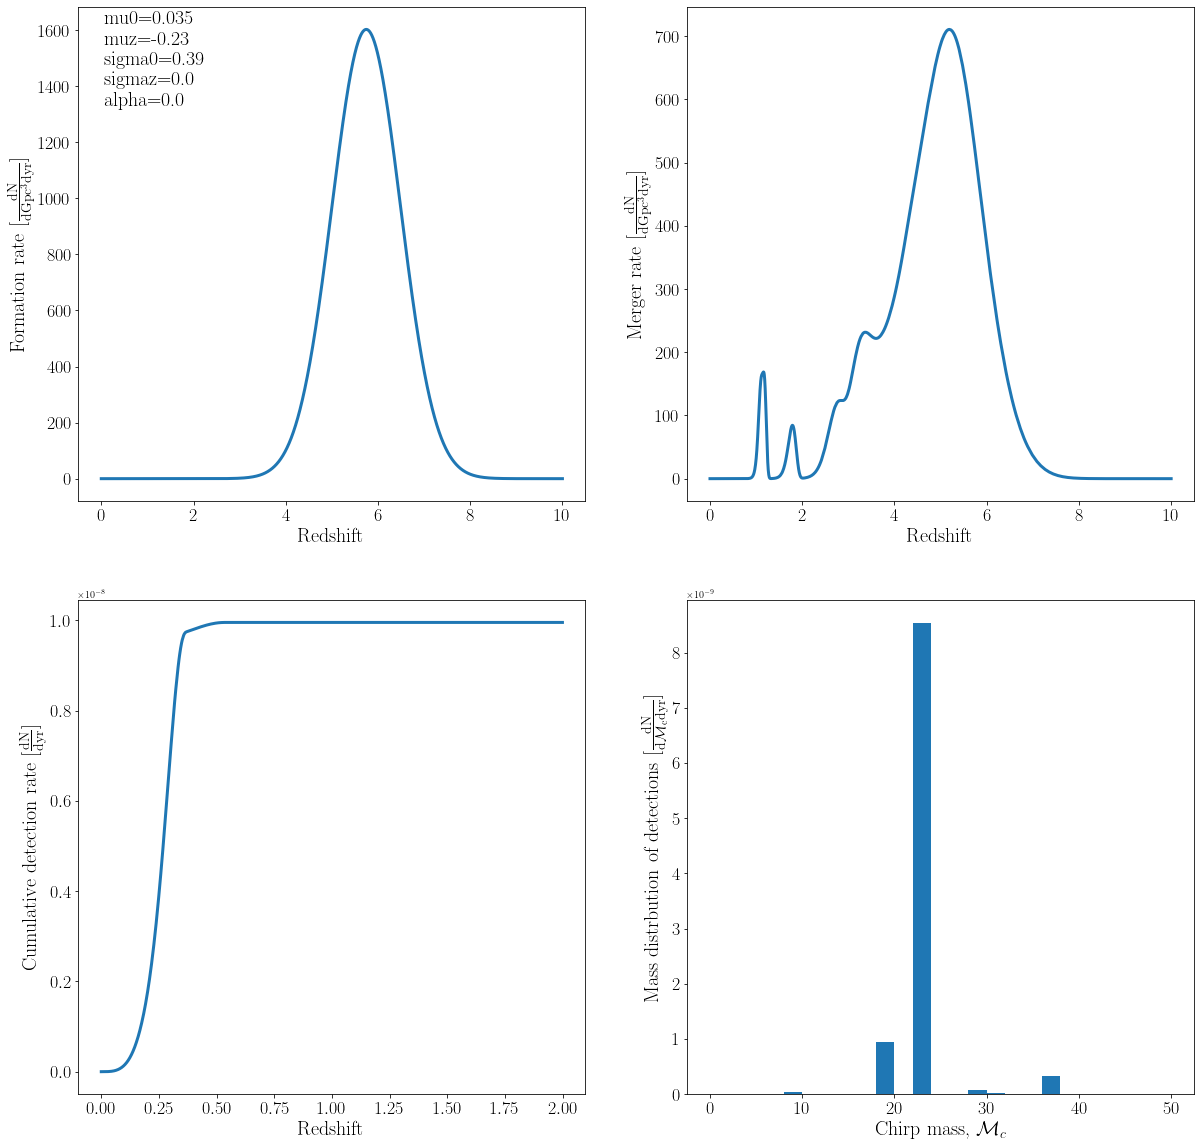

In [92]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

axes[0,0].plot(redshifts, total_formation_rate, lw=lw)
axes[0,0].set_xlabel('Redshift', fontsize=fs)
axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[0,1].plot(redshifts, total_merger_rate, lw=lw)
axes[0,1].set_xlabel('Redshift', fontsize=fs)
axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[1,0].plot(redshifts[:len(cumulative_detection_rate)], cumulative_detection_rate, lw=lw)
axes[1,0].set_xlabel('Redshift', fontsize=fs)
axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

axes[1,1].hist(chirp_masses, weights=detection_rate_by_binary, bins=25, range=(0, 50))
axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

#########################
#Plotvalues

# Add text upper left corner
axes[0,0].text(0.05,0.8, "mu0=%s \nmuz=%s \nsigma0=%s \nsigmaz=%s \nalpha=%s"%(mu0,muz,sigma0,sigmaz,alpha), transform=axes[0,0].transAxes, size = fs) 

for ax in axes.flatten():
    ax.tick_params(labelsize=0.9*fs)

# Save and show :)
plt.savefig(pathData +'Rate_Info'+"mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s"%(mu0,muz,alpha,sigma0, sigmaz)+'.png', bbox_inches='tight') 
plt.show()


# You can do all of this at once by running:


In [ ]:


detection_rate, formation_rate, merger_rate, redshifts, COMPAS = CI.find_detection_rate(pathData, filename="COMPAS_Output.h5", dco_type="BBH", weight_column=None,
                        merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
                        max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
                        m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=0.7,
                        aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
                        mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
                        min_logZ=-12.0, max_logZ=0.0, step_logZ=0.01,
                        sensitivity="O1", snr_threshold=8, 
                        Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
                        snr_max=1000.0, snr_step=0.1)



In [82]:
print(detection_rate)

[[1.00197609e-16 7.17012740e-16 1.98934480e-15 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.29879390e-19 4.46115185e-18 1.22505149e-17 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.01407665e-19 4.96757343e-18 1.36406739e-17 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.93953868e-19 3.49874329e-18 9.60849697e-18 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.93953868e-19 3.49874329e-18 9.60849697e-18 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.74272322e-19 3.35938323e-18 9.21195594e-18 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
